<a href="https://colab.research.google.com/github/zolfaShefreie/Spark_ML/blob/main/sparkML_customerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download dataset

In [1]:
import requests

In [2]:
customer_url = 'https://raw.githubusercontent.com/zolfaShefreie/Spark_ML/main/data.csv'
customer_file_path = "data.csv"

In [3]:
def download_file(url: str, file_path):
  """
  download file and save on file path
  """
  file_content = requests.get(url).text
  file = open(file_path, 'w')
  file.write(file_content)
  file.close()

In [4]:
download_file(customer_url, customer_file_path)

#pyspark setup

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 29 kB/s 
     |████████████████████████████████| 198 kB 63.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=144d3c473f1d588133284606cfd55175fe2addb94864bf6b7efa9b5c189e9b50
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [6]:
import pyspark
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName('spark_ml').getOrCreate()
sc = spark.sparkContext

#imports

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [252]:
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

#load data

In [10]:
df = spark.read.csv(customer_file_path, inferSchema=True, header=True)

In [11]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



#Analyse data

##basics

تعداد‌ها به تعداد سطر‌های کل دیتافریم نمی‌خوره

In [12]:
df.summary().show()

+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------+
|summary|customerID|gender|      SeniorCitizen|Partner|Dependents|           tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges| Label|
+-------+----------+------+-------------------+-------+----------+-----------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------+
|  count|    229737|229755|             229724| 229765|    229748| 

In [13]:
df.count()

229990

شمردن نال‌ها

In [14]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

In [254]:
categorical_cols = {'gender', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                    'PaymentMethod', 'Label', "Contract"}

In [258]:
stages = list()
for col in categorical_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col+"Index")
    one_hot = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col+'CVect'])
    stages += [string_indexer, one_hot]

pipeline = Pipeline(stages=stages)
normalized_model = pipeline.fit(df)
df2 = normalized_model.transform(df)

In [259]:
vector_col = "corr_features"
columns = [col+"CVect" for col in categorical_cols] + ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(df2).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


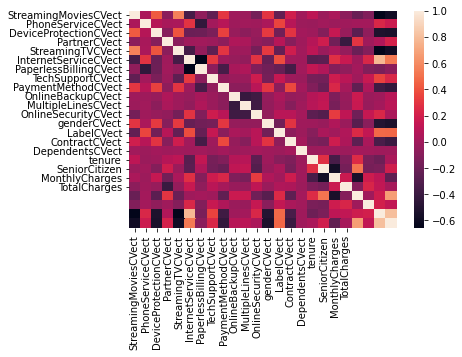

In [273]:
corr = matrix.collect()[0][matrix.columns[0]].toArray()
sns.heatmap(corr, 
            xticklabels=columns,
            yticklabels=columns)

##relation between seniorCitizen and phone and internet service

طبق نام ستون این ستون برای نشان دادن اینکه این فرد سالخورده است یا نه اما مقادیر ۱۴ و ۱۷ برای آن اشتباه است

In [15]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+------+
|SeniorCitizen| count|
+-------------+------+
|          0.0|190739|
|         null|   266|
|          1.0| 38185|
|         14.0|   794|
|         17.0|     6|
+-------------+------+



حدس: بیشتر افراد سالخورده سرویس موبایل و یا سرویس اینترنت ندارند. طبق نتایج پایین حدس رد شد.

In [16]:
df.select(['SeniorCitizen', 'PhoneService']).\
filter((df.SeniorCitizen == 1) | (df.SeniorCitizen == 0)).\
groupBy(['SeniorCitizen', 'PhoneService']).count().show()

+-------------+------------+------+
|SeniorCitizen|PhoneService| count|
+-------------+------------+------+
|          0.0|        null|   142|
|          1.0|        null|    42|
|          1.0|         Yes| 34867|
|          0.0|          No| 18416|
|          1.0|          No|  3276|
|          0.0|         Yes|172181|
+-------------+------------+------+



In [17]:
df.select(['SeniorCitizen', 'InternetService']).\
filter((df.SeniorCitizen == 1) | (df.SeniorCitizen == 0)).\
groupBy(['SeniorCitizen', 'InternetService']).count().show()

+-------------+---------------+-----+
|SeniorCitizen|InternetService|count|
+-------------+---------------+-----+
|          0.0|           null|  127|
|          0.0|    Fiber optic|74959|
|          1.0|           null|   26|
|          1.0|    Fiber optic|27215|
|          0.0|             No|44578|
|          1.0|            DSL| 8807|
|          1.0|             No| 2137|
|          0.0|            DSL|71075|
+-------------+---------------+-----+



کسانی که سرویس موبایل ندارند سرویس اینترنت فیبر ندارند بااینکه مقادیری نال می‌باشد ولی می‌توان نتیجه گرفت کسانی که سرویس موبایل ندارند حتما سرویس اینترنت دارند و کسانی که سرویس اینترنت ندارند حتما سرویس موبایل دارند.

In [18]:
df.select(['PhoneService', 'InternetService']).\
groupBy(['PhoneService', 'InternetService']).count().show()

+------------+---------------+------+
|PhoneService|InternetService| count|
+------------+---------------+------+
|          No|            DSL| 21773|
|        null|           null|    73|
|         Yes|             No| 46859|
|        null|    Fiber optic|    78|
|         Yes|            DSL| 58290|
|        null|             No|    58|
|          No|           null|    44|
|         Yes|           null|   113|
|         Yes|    Fiber optic|102642|
|        null|            DSL|    60|
+------------+---------------+------+



##relation between PhoneService and MultipleLines

اگر شخصی سرویس موبایل نداشته باشد باید در این دو ستون یکسان ثبت شود بنابراین نال‌ها به راحتی پر می‌شوند و حالت نقض هم وجود ندارد

بیشتر افرادی که سرویس موبایل دارند چند خطه‌اند.

In [19]:
df.select(['MultipleLines', 'PhoneService']).groupBy(['MultipleLines', 'PhoneService']).count().show()

+----------------+------------+------+
|   MultipleLines|PhoneService| count|
+----------------+------------+------+
|No phone service|        null|    44|
|No phone service|          No| 21773|
|             Yes|         Yes|125337|
|            null|        null|    79|
|              No|        null|    80|
|            null|          No|    44|
|            null|         Yes|   140|
|             Yes|        null|    66|
|              No|         Yes| 82427|
+----------------+------------+------+



## relation between InternetService and columns that looks need internet service

In [20]:
internet_count=df.select('InternetService').groupBy('InternetService').count().withColumn('total_count', col('count')).drop('count')
internet_count.show()

+---------------+-----------+
|InternetService|total_count|
+---------------+-----------+
|           null|        230|
|    Fiber optic|     102720|
|             No|      46917|
|            DSL|      80123|
+---------------+-----------+



طبق نتایج زیر برخی از نال ها مربوط به نداشتن سرویس اینترنت می‌توانند پر شوند.<br/>
بیشتر افرادی که دی اس ال دارند امنیت دارند و بیشتر افرادی که فیبر دارند امنیت ندارند. 

In [21]:
df.select(['InternetService', 'OnlineSecurity']).groupBy(['InternetService', 'OnlineSecurity']).count().show()

+---------------+-------------------+-----+
|InternetService|     OnlineSecurity|count|
+---------------+-------------------+-----+
|            DSL|                Yes|51003|
|    Fiber optic|                Yes|40755|
|           null|               null|   65|
|    Fiber optic|               null|   61|
|             No|No internet service|46869|
|           null|                 No|   72|
|             No|               null|   48|
|           null|                Yes|   42|
|    Fiber optic|                 No|61904|
|            DSL|               null|   56|
|            DSL|                 No|29064|
|           null|No internet service|   51|
+---------------+-------------------+-----+



In [22]:
df.select(['InternetService', 'OnlineSecurity']).\
groupBy(['InternetService', 'OnlineSecurity']).count().\
join(internet_count, ['InternetService']).\
withColumn('percent', col('count')*100/col('total_count')).\
show()

+---------------+-------------------+-----+-----------+-------------------+
|InternetService|     OnlineSecurity|count|total_count|            percent|
+---------------+-------------------+-----+-----------+-------------------+
|    Fiber optic|                 No|61904|     102720|  60.26479750778816|
|    Fiber optic|               null|   61|     102720|0.05938473520249221|
|    Fiber optic|                Yes|40755|     102720|  39.67581775700935|
|             No|               null|   48|      46917|0.10230833173476565|
|             No|No internet service|46869|      46917|  99.89769166826524|
|            DSL|                 No|29064|      80123|  36.27422837387517|
|            DSL|               null|   56|      80123|0.06989254021941266|
|            DSL|                Yes|51003|      80123|  63.65587908590542|
+---------------+-------------------+-----+-----------+-------------------+



نال‌های مربوط به نداشتن سرویس اینترنتی راحت پر می‌شوند. بیشتر افراد بک‌آپ دارند. با نسبت ۶۰ به ۴۰ که برای هر دو نوع صدق می‌کند 

In [23]:
df.select(['InternetService', 'OnlineBackup']).groupBy(['InternetService', 'OnlineBackup']).count().show()

+---------------+-------------------+-----+
|InternetService|       OnlineBackup|count|
+---------------+-------------------+-----+
|            DSL|                Yes|47760|
|    Fiber optic|                Yes|61407|
|           null|               null|   78|
|    Fiber optic|               null|   61|
|             No|No internet service|46868|
|           null|                 No|   63|
|             No|               null|   49|
|           null|                Yes|   41|
|    Fiber optic|                 No|41252|
|            DSL|               null|   55|
|            DSL|                 No|32308|
|           null|No internet service|   48|
+---------------+-------------------+-----+



In [24]:
df.select(['InternetService', 'OnlineBackup']).\
groupBy(['InternetService', 'OnlineBackup']).count().\
join(internet_count, ['InternetService']).\
withColumn('percent', col('count')*100/col('total_count')).\
show()

+---------------+-------------------+-----+-----------+-------------------+
|InternetService|       OnlineBackup|count|total_count|            percent|
+---------------+-------------------+-----+-----------+-------------------+
|    Fiber optic|                 No|41252|     102720|  40.15965732087228|
|    Fiber optic|               null|   61|     102720|0.05938473520249221|
|    Fiber optic|                Yes|61407|     102720|  59.78095794392523|
|             No|               null|   49|      46917|0.10443975531257327|
|             No|No internet service|46868|      46917|  99.89556024468743|
|            DSL|                 No|32308|      80123|  40.32300338229972|
|            DSL|               null|   55|      80123|  0.068644459144066|
|            DSL|                Yes|47760|      80123|  59.60835215855622|
+---------------+-------------------+-----+-----------+-------------------+



بیشتر افراد بک آپ دارند پس بهتر از مقادیر نال با استفاده از مد پر شود (به جز دسته‌ی ذکر شده)

In [25]:
df.select('OnlineBackup').groupBy('OnlineBackup').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+------+-------------------+
|       OnlineBackup| count|            percent|
+-------------------+------+-------------------+
|               null|   243|0.10565676768555154|
|                 No| 73623|  32.01139179964346|
|                Yes|109208| 47.483803643636676|
|No internet service| 46916| 20.399147789034306|
+-------------------+------+-------------------+



نتایج مانند مورد قبلی

In [26]:
df.select(['InternetService', 'DeviceProtection']).groupBy(['InternetService', 'DeviceProtection']).count().show()

+---------------+-------------------+-----+
|InternetService|   DeviceProtection|count|
+---------------+-------------------+-----+
|            DSL|                Yes|48552|
|    Fiber optic|                Yes|60058|
|           null|               null|   76|
|    Fiber optic|               null|   68|
|             No|No internet service|46866|
|             No|               null|   51|
|           null|                 No|   75|
|           null|                Yes|   35|
|    Fiber optic|                 No|42594|
|            DSL|               null|   59|
|            DSL|                 No|31512|
|           null|No internet service|   44|
+---------------+-------------------+-----+



In [27]:
df.select('DeviceProtection').groupBy('DeviceProtection').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+------+-------------------+
|   DeviceProtection| count|            percent|
+-------------------+------+-------------------+
|               null|   254|0.11043958432975347|
|                 No| 74181| 32.254011043958435|
|                Yes|108645|  47.23901039175616|
|No internet service| 46910|  20.39653897995565|
+-------------------+------+-------------------+



بیشتر افرادی که دی اس ال دارند تک ساپورت دارند ولی سایر افراد که فیبر دارند دارای تک ساپورت نیستند

In [28]:
df.select(['InternetService', 'TechSupport']).groupBy(['InternetService', 'TechSupport']).count().show()

+---------------+-------------------+-----+
|InternetService|        TechSupport|count|
+---------------+-------------------+-----+
|            DSL|                Yes|50669|
|    Fiber optic|                Yes|41595|
|           null|               null|   91|
|    Fiber optic|               null|   52|
|             No|No internet service|46860|
|             No|               null|   57|
|           null|                 No|   65|
|           null|                Yes|   36|
|    Fiber optic|                 No|61073|
|            DSL|               null|   64|
|            DSL|                 No|29390|
|           null|No internet service|   38|
+---------------+-------------------+-----+



در کل به نظر می‌رسد نسبت این دو، برابر باشند بنابراین بهتر است بر اساس اینترنت سرویس پر شود

In [29]:
df.select('TechSupport').groupBy('TechSupport').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+-----+-------------------+
|        TechSupport|count|            percent|
+-------------------+-----+-------------------+
|               null|  264|0.11478759946084613|
|                 No|90528|   39.3617113787556|
|                Yes|92300|  40.13217965998522|
|No internet service|46898|  20.39132136179834|
+-------------------+-----+-------------------+



طبق نتایج پایین دسته از نال ها بهتر است با مد پر شوند

In [30]:
df.select(['InternetService', 'StreamingTV']).groupBy(['InternetService', 'StreamingTV']).count().show()

+---------------+-------------------+-----+
|InternetService|        StreamingTV|count|
+---------------+-------------------+-----+
|            DSL|                Yes|41715|
|    Fiber optic|                Yes|70243|
|           null|               null|   71|
|    Fiber optic|               null|   66|
|             No|No internet service|46870|
|           null|                 No|   55|
|             No|               null|   47|
|           null|                Yes|   57|
|    Fiber optic|                 No|32411|
|            DSL|               null|   65|
|            DSL|                 No|38343|
|           null|No internet service|   47|
+---------------+-------------------+-----+



In [31]:
df.select('StreamingTV').groupBy('StreamingTV').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+------+-------------------+
|        StreamingTV| count|            percent|
+-------------------+------+-------------------+
|               null|   249|0.10826557676420714|
|                 No| 70809|  30.78786034175399|
|                Yes|112015|  48.70429149093439|
|No internet service| 46917| 20.399582590547414|
+-------------------+------+-------------------+



In [32]:
df.select(['InternetService', 'StreamingMovies']).groupBy(['InternetService', 'StreamingMovies']).count().show()

+---------------+-------------------+-----+
|InternetService|    StreamingMovies|count|
+---------------+-------------------+-----+
|            DSL|                Yes|42658|
|    Fiber optic|                Yes|70517|
|           null|               null|   65|
|    Fiber optic|               null|   55|
|             No|No internet service|46866|
|             No|               null|   51|
|           null|                 No|   62|
|           null|                Yes|   50|
|    Fiber optic|                 No|32148|
|            DSL|               null|   48|
|            DSL|                 No|37417|
|           null|No internet service|   53|
+---------------+-------------------+-----+



In [33]:
df.select('StreamingMovies').groupBy('StreamingMovies').count().withColumn('percent', col('count')*100/df.count()).show()

+-------------------+------+-------------------+
|    StreamingMovies| count|            percent|
+-------------------+------+-------------------+
|               null|   219|0.09522153137092917|
|                 No| 69627| 30.273924953258838|
|                Yes|113225|   49.2304013217966|
|No internet service| 46919| 20.400452193573635|
+-------------------+------+-------------------+



##relation between StreamingMovies and StreamingTV

رابطه‌ی خاصی دیده نشد

In [34]:
df.select(['StreamingTV', 'StreamingMovies']).groupBy(['StreamingTV', 'StreamingMovies']).count().show()

+-------------------+-------------------+-----+
|        StreamingTV|    StreamingMovies|count|
+-------------------+-------------------+-----+
|                Yes|                Yes|87531|
|               null|               null|   72|
|                 No|                 No|45136|
|                Yes|                 No|24428|
|No internet service|No internet service|46872|
|                 No|               null|   46|
|               null|                 No|   63|
|               null|                Yes|   67|
|                Yes|               null|   56|
|                 No|                Yes|25627|
|               null|No internet service|   47|
|No internet service|               null|   45|
+-------------------+-------------------+-----+



##relation between OnlineSecurity and OnlineBackup and DeviceProtection

In [35]:
df.select(['OnlineSecurity', 'OnlineBackup']).groupBy(['OnlineSecurity', 'OnlineBackup']).count().show()

+-------------------+-------------------+-----+
|     OnlineSecurity|       OnlineBackup|count|
+-------------------+-------------------+-----+
|                Yes|                Yes|59862|
|               null|               null|   61|
|                 No|                 No|41668|
|                Yes|                 No|31884|
|No internet service|No internet service|46866|
|                 No|               null|   74|
|               null|                 No|   71|
|                Yes|               null|   54|
|               null|                Yes|   48|
|                 No|                Yes|49298|
|No internet service|               null|   54|
|               null|No internet service|   50|
+-------------------+-------------------+-----+



In [36]:
df.select(['OnlineSecurity', 'DeviceProtection']).groupBy(['OnlineSecurity', 'DeviceProtection']).count().show()

+-------------------+-------------------+-----+
|     OnlineSecurity|   DeviceProtection|count|
+-------------------+-------------------+-----+
|                Yes|                Yes|59738|
|               null|               null|   72|
|                 No|                 No|42091|
|                Yes|                 No|32014|
|No internet service|No internet service|46860|
|                 No|               null|   74|
|               null|                 No|   76|
|               null|                Yes|   32|
|                Yes|               null|   48|
|                 No|                Yes|48875|
|No internet service|               null|   60|
|               null|No internet service|   50|
+-------------------+-------------------+-----+



In [37]:
df.select(['DeviceProtection', 'OnlineBackup']).groupBy(['DeviceProtection', 'OnlineBackup']).count().show()

+-------------------+-------------------+-----+
|   DeviceProtection|       OnlineBackup|count|
+-------------------+-------------------+-----+
|                Yes|                Yes|69810|
|               null|               null|   73|
|                 No|                 No|34745|
|                Yes|                 No|38802|
|No internet service|No internet service|46858|
|               null|                 No|   76|
|                 No|               null|   85|
|                Yes|               null|   33|
|               null|                Yes|   47|
|                 No|                Yes|39351|
|No internet service|               null|   52|
|               null|No internet service|   58|
+-------------------+-------------------+-----+



طبق نتایج بیشتر افراد از بین این سه مورد حداقل ۲ مورد را دارند. جایگاه بعدی برای افرادی هست که هر سه مورد را دارند جایگاه بعدی مربود به افرادی است هیچ مورد را ندارند و در آخر کسانی که فقط دیوایس پروتکشن دارند.

In [38]:
df.select(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']).groupBy(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']).count().show()

+-------------------+-------------------+-------------------+-----+
|     OnlineSecurity|       OnlineBackup|   DeviceProtection|count|
+-------------------+-------------------+-------------------+-----+
|                Yes|                Yes|                 No|19014|
|                Yes|                Yes|               null|   12|
|                Yes|               null|                Yes|    5|
|               null|                Yes|                Yes|   13|
|               null|               null|               null|   22|
|                 No|                 No|               null|   32|
|                 No|               null|                 No|   35|
|               null|                 No|                 No|   36|
|               null|                Yes|                 No|   21|
|                Yes|               null|                 No|   31|
|                Yes|                 No|               null|   18|
|                 No|                Yes|       

##relation between Partner and Dependents and SeniorCitizen

حدس: کسی که پارنتر داره صد در صد خویشاوند نیز دارد. رد شد<br/>
اما بیشتر کسانی که پارتنر ندارند خوشاوند هم ندارند و بیشتر کسانی که خویشاوند دارند پارتنر هم دارند 

In [39]:
df.select(['Partner', 'Dependents']).groupBy(['Partner', 'Dependents']).count().show()

+-------+----------+-----+
|Partner|Dependents|count|
+-------+----------+-----+
|    Yes|       Yes|73033|
|   null|      null|   64|
|     No|        No|76884|
|    Yes|        No|71007|
|   null|        No|   99|
|     No|      null|  101|
|    Yes|      null|   77|
|   null|       Yes|   62|
|     No|       Yes| 8663|
+-------+----------+-----+



بیشتر افراد پارتنر دارند پس بهتر است با مد پر شود

In [40]:
df.select(['Partner', 'SeniorCitizen']).groupBy(['Partner', 'SeniorCitizen']).count().show()

+-------+-------------+------+
|Partner|SeniorCitizen| count|
+-------+-------------+------+
|   null|          0.0|   127|
|    Yes|          0.0|119647|
|   null|         null|    70|
|    Yes|         14.0|   534|
|   null|          1.0|    28|
|    Yes|         17.0|     6|
|     No|          0.0| 70965|
|     No|         null|   101|
|    Yes|         null|    95|
|     No|         14.0|   260|
|     No|          1.0| 14322|
|    Yes|          1.0| 23835|
+-------+-------------+------+



بیشتر افراد خویشاوند ندارند پس بهتر است با مد پر شود

In [41]:
df.select(['SeniorCitizen', 'Dependents']).groupBy(['SeniorCitizen', 'Dependents']).count().show()

+-------------+----------+------+
|SeniorCitizen|Dependents| count|
+-------------+----------+------+
|          0.0|      null|   133|
|         17.0|        No|     6|
|         null|      null|    72|
|          1.0|      null|    37|
|         14.0|       Yes|   288|
|          1.0|       Yes|  4079|
|          0.0|        No|113286|
|          1.0|        No| 34069|
|         null|        No|   123|
|         null|       Yes|    71|
|          0.0|       Yes| 77320|
|         14.0|        No|   506|
+-------------+----------+------+



In [42]:
df.select('Dependents').groupBy('Dependents').count().show()

+----------+------+
|Dependents| count|
+----------+------+
|      null|   242|
|        No|147990|
|       Yes| 81758|
+----------+------+



##relations between tenure and MonthlyCharges and TotalCharges

In [43]:
tenure_list = [each.tenure for each in df.select('tenure').filter(~col('tenure').isNull()).collect()]

مقادیر منفی غیرقابل قبوله

In [44]:
min(tenure_list), max(tenure_list)

(-598.0, 72.0)

{'boxes': [<matplotlib.lines.Line2D at 0x7f13234d9110>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1325ce11d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1325ceb210>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1325ce1c90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f13234d9710>,
  <matplotlib.lines.Line2D at 0x7f13234d9c50>]}

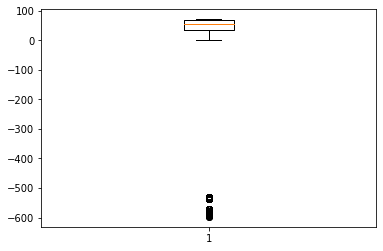

In [45]:
plt.boxplot(tenure_list)

(array([1.48000e+02, 1.60000e+02, 2.80000e+01, 0.00000e+00, 1.24000e+02,
        1.40000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.40900e+03,
        1.63950e+04, 2.42080e+04, 3.44270e+04, 4.72570e+04, 1.04469e+05]),
 array([-598. , -584.6, -571.2, -557.8, -544.4, -531. , -517.6, -504.2,
        -490.8, -477.4, -464. , -450.6, -437.2, -423.8, -410.4, -397. ,
        -383.6, -370.2, -356.8, -343.4, -330. , -316.6, -303.2, -289.8,
        -276.4, -263. , -249.6, -236.2, -222.8, -209

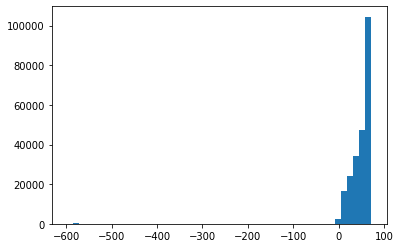

In [46]:
plt.hist(tenure_list, bins=50)

نشون میده یه سری مقادیر غیر قابل قبوله برای شارژ ماهیانه چون حتی از مجموع هم بالاتره

In [47]:
MonthlyCharges_list = [each.MonthlyCharges for each in df.select('MonthlyCharges').filter(~col('MonthlyCharges').isNull()).collect()]

{'boxes': [<matplotlib.lines.Line2D at 0x7f13291a82d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1326504950>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f13264f0250>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1326504c90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f13264e5710>,
  <matplotlib.lines.Line2D at 0x7f13264e5b50>]}

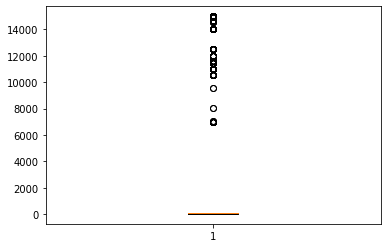

In [48]:
plt.boxplot(MonthlyCharges_list)

In [49]:
min(MonthlyCharges_list), max(MonthlyCharges_list)

(18.25, 14990.0)

(array([2.28747e+05, 0.00000e+00, 2.80000e+01, 3.74000e+02, 5.98000e+02]),
 array([   18.25,  3012.6 ,  6006.95,  9001.3 , 11995.65, 14990.  ]),
 <a list of 5 Patch objects>)

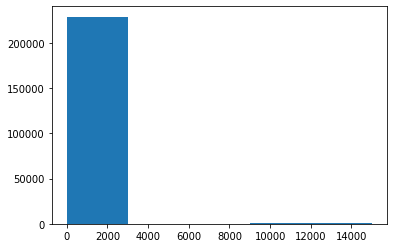

In [50]:
plt.hist(MonthlyCharges_list, bins=5)

In [51]:
TotalCharges_list = [each.TotalCharges for each in df.select('TotalCharges').filter(~col('TotalCharges').isNull()).collect()]

{'boxes': [<matplotlib.lines.Line2D at 0x7f1323410190>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1323418250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f132381f290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1323418d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1323410790>,
  <matplotlib.lines.Line2D at 0x7f1323410cd0>]}

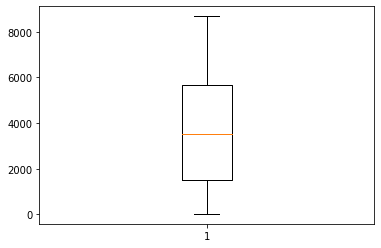

In [52]:
plt.boxplot(TotalCharges_list)

(array([67846., 45625., 46584., 45335., 24349.]),
 array([  18.8, 1752. , 3485.2, 5218.4, 6951.6, 8684.8]),
 <a list of 5 Patch objects>)

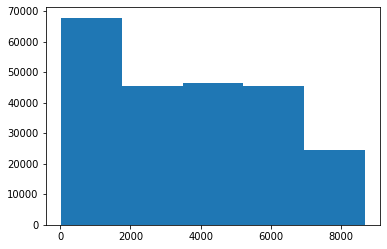

In [53]:
plt.hist(TotalCharges_list, bins=5)

In [54]:
condition = ((~col('TotalCharges').isNull())&(~col('MonthlyCharges').isNull())&(~col('tenure').isNull())&((~col('Label').isNull()))&
             (col('MonthlyCharges')<1000) & (col('tenure')>0))

In [55]:
tenure_list = [each.tenure for each in df.select('tenure').filter(condition).collect()]
MonthlyCharges_list = [each.MonthlyCharges for each in df.select('MonthlyCharges').filter(condition).collect()]
TotalCharges_list = [each.TotalCharges for each in df.select('TotalCharges').filter(condition).collect()]
label_list = [each.Label for each in df.select('Label').filter(condition).collect()]

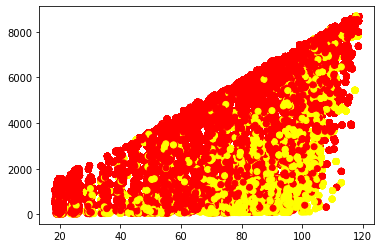

In [56]:
colors = {'No': 'red', "Yes": 'yellow'}
# plt.figure(figsize=(20, 10))
plt.scatter(MonthlyCharges_list, TotalCharges_list, c=[colors[x] for x in label_list])

تقریبا رو یک خط راست قرار گرفته اگه دقیقا از فرمول پیروی کنه میشه توتال چارچ رو حذف کرد چون اطلاعاتی که میده تقریبا یکیه

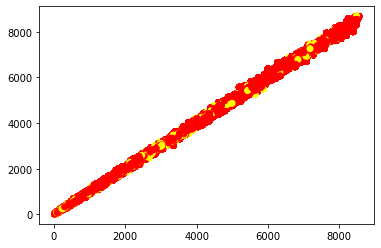

In [57]:
plt.scatter([x*y for x, y in zip(MonthlyCharges_list, tenure_list)], TotalCharges_list, c=[colors[x] for x in label_list])

In [58]:
line_condition = (col('tenure')*col('MonthlyCharges')==col('TotalCharges'))
df.filter(condition & line_condition).count()

626

طبق نتایج دقیقا برابر نیست که نشون میده می‌تونه تغییراتی شارژ ماهیانه در ماه‌های مختلف داشته باشه ولی مقادیر نال رو تقریبا میشه با این قانون پر کرد و بقیه موارد رو با میانگین

In [59]:
df.filter(condition & (~line_condition)).count()

227159

In [60]:
condition = ((col('TotalCharges').isNull())&(col('MonthlyCharges').isNull())&(col('tenure').isNull()))
df.filter(condition).count()

15

##relation between PaperlessBilling and PaymentMethod

حدس: فقط برای میل چک ستون دیگر حالت خیر دارد. حدس رد شد اما فقط توی حالت میلدچک هست که بیشتر مقدار نه هستش بقیه موارد توی حالت یس قرار دارند

In [61]:
df.select(['PaymentMethod', 'PaperlessBilling']).groupBy(['PaymentMethod', 'PaperlessBilling']).count().show()

+--------------------+----------------+-----+
|       PaymentMethod|PaperlessBilling|count|
+--------------------+----------------+-----+
|Credit card (auto...|            null|   31|
|                null|            null|   84|
|Credit card (auto...|              No|27988|
|        Mailed check|            null|   23|
|Bank transfer (au...|              No|28453|
|        Mailed check|             Yes|14159|
|Bank transfer (au...|            null|   48|
|Credit card (auto...|             Yes|38439|
|                null|              No|   40|
|                null|             Yes|  122|
|    Electronic check|              No|15351|
|    Electronic check|             Yes|44615|
|Bank transfer (au...|             Yes|39270|
|    Electronic check|            null|   71|
|        Mailed check|              No|21296|
+--------------------+----------------+-----+



In [62]:
df.select('PaymentMethod').groupBy('PaymentMethod').count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...|66458|
|                null|  246|
|        Mailed check|35478|
|Bank transfer (au...|67771|
|    Electronic check|60037|
+--------------------+-----+



In [63]:
df.select('PaperlessBilling').groupBy('PaperlessBilling').count().show()

+----------------+------+
|PaperlessBilling| count|
+----------------+------+
|            null|   257|
|              No| 93128|
|             Yes|136605|
+----------------+------+



## relation between PaymentMethod and Contract

طبق نتایج زیر:

*   بیشتر در حالت پرداخت با الکترونیک چک ماه به ماه قرار داد هستش
*   برای باقی حالت‌ها قرارداد بیشتر دو ساله ست
*   توی حالت قرار داد یکساله و دوساله کریدت کارت بیشترین و توی حالت ماه به ماه میلد چک بالاترین تعداد رو داره



In [64]:
df.select(['PaymentMethod', 'Contract']).groupBy(['PaymentMethod', 'Contract']).count().show()

+--------------------+--------------+-----+
|       PaymentMethod|      Contract|count|
+--------------------+--------------+-----+
|Credit card (auto...|          null|   32|
|        Mailed check|      One year| 9939|
|                null|Month-to-month|   59|
|        Mailed check|      Two year|16487|
|                null|          null|   70|
|                null|      One year|   24|
|        Mailed check|          null|   23|
|Bank transfer (au...|      One year|18007|
|Bank transfer (au...|Month-to-month|14745|
|                null|      Two year|   93|
|Bank transfer (au...|          null|   44|
|Bank transfer (au...|      Two year|34975|
|    Electronic check|      Two year|10375|
|Credit card (auto...|      One year|18263|
|Credit card (auto...|      Two year|35043|
|    Electronic check|          null|   61|
|        Mailed check|Month-to-month| 9029|
|    Electronic check|Month-to-month|33469|
|Credit card (auto...|Month-to-month|13120|
|    Electronic check|      One 

#data preprocess and feature engineering

##missing value and outlier handling

###customerID

تعداد مقادیر نال در این ستون

In [65]:
df.select(count(when(isnan("customerID") | col("customerID").isNull(), "customerID")).alias('customerID')).show()

+----------+
|customerID|
+----------+
|       253|
+----------+



چون یکمی غیرعادی است که آیدی یا شناسه نال باشد چند ستون از آن چک می‌شود

In [66]:
df.filter(col('customerID').isNull()).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|      null|Female|          0.0|     No|        No|  36.0|          N

مقادیر نال با مقدار دیگری پر نمی‌شود زیرا این ستون در انتها برای آموزش مدل حذف خواهد شد زیرا مدل براساس پارامترها تصمیم میگیرد برای برچسب دهی و این ستون شناسه ی مشتری می‌باشد و مقادیر تکراری در آن وجود ندارد

###gender

In [67]:
df.select('gender').distinct().collect()

[Row(gender=None), Row(gender='Female'), Row(gender='Male')]

In [68]:
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|  null|   235|
|Female|113452|
|  Male|116303|
+------+------+



In [69]:
mode_gender = df.groupBy('gender').count().agg({'count': 'max'}).join(df.groupBy('gender').count()).filter(col('max(count)')==col('count'))
mode_gender = mode_gender.select('gender').collect()[0].gender
mode_gender

'Male'

In [70]:
df = df.fillna(mode_gender, subset=["gender"])

به‌دلیل وجود دو مقدار یونیک، می‌توان مقادیر را به صفر و یک نگاشت کرد<br/>


*   Male => 0
*   Female => 1



In [71]:
# df = df.withColumn("gender", when(df["gender"] == 'Male', 0).otherwise(1))

###SeniorCitizen

In [72]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+------+
|SeniorCitizen| count|
+-------------+------+
|          0.0|190739|
|         null|   266|
|          1.0| 38185|
|         14.0|   794|
|         17.0|     6|
+-------------+------+



In [73]:
df = df.withColumn("SeniorCitizen", when((df.SeniorCitizen == 17.0) | (df.SeniorCitizen == 14.0), None).otherwise(col('SeniorCitizen')))

In [74]:
df = df.fillna(0, subset=["SeniorCitizen"])

In [75]:
df.select('SeniorCitizen').groupBy('SeniorCitizen').count().show()

+-------------+------+
|SeniorCitizen| count|
+-------------+------+
|          0.0|191805|
|          1.0| 38185|
+-------------+------+



###Partner

لازم به ران شدن سلول پایین نیست زیرا با مد پر می‌شود که همان یس است

In [76]:
df = df.withColumn("Partner", when((isnan("Partner") | col("Partner").isNull()) & (df.Dependents == "Yes"), "Yes").otherwise(col('Partner')))

In [77]:
df.select('Partner').groupBy("Partner").count().show()

+-------+------+
|Partner| count|
+-------+------+
|   null|   163|
|     No| 85648|
|    Yes|144179|
+-------+------+



In [78]:
df = df.fillna('Yes', ['Partner'])

In [79]:
# df = df.withColumn("Partner", when(df["Partner"] == 'Yes', 1).otherwise(0))

###Dependents

In [80]:
df.select('Dependents').groupBy("Dependents").count().show()

+----------+------+
|Dependents| count|
+----------+------+
|      null|   242|
|        No|147990|
|       Yes| 81758|
+----------+------+



In [81]:
df = df.fillna('No', ['Dependents'])

In [82]:
df = df.withColumn("Dependents", when(df["Dependents"] == 'Yes', 'Yes').otherwise('No'))

###PhoneService

In [83]:
df = df.withColumn("PhoneService", when((isnan("PhoneService") | col("PhoneService").isNull()) & (df.MultipleLines == "No phone service"), "No").otherwise(col('PhoneService')))

In [84]:
df = df.withColumn("PhoneService", when((isnan("PhoneService") | col("PhoneService").isNull()) & (df.InternetService == "No"), "Yes").otherwise(col('PhoneService')))

In [85]:
df.groupBy('PhoneService').count().show()

+------------+------+
|PhoneService| count|
+------------+------+
|        null|   167|
|          No| 21861|
|         Yes|207962|
+------------+------+



In [86]:
df = df.fillna("Yes", subset=["PhoneService"])

In [87]:
# df = df.withColumn("PhoneService", when(df["PhoneService"] == 'No', 0).otherwise(1))

###MultipleLines

In [88]:
df = df.withColumn("MultipleLines", when((df.PhoneService == 0), "No phone service").otherwise(col('MultipleLines')))

In [89]:
df.groupBy('MultipleLines').count().show()

+----------------+------+
|   MultipleLines| count|
+----------------+------+
|No phone service| 21817|
|            null|   263|
|              No| 82507|
|             Yes|125403|
+----------------+------+



In [90]:
df = df.fillna("Yes", subset=["MultipleLines"])

نگاشتی برای پاسخ باینتری انجام میشود. برای افرادی که تلفن سرویس ندارند نیز نه در نظر گرفته می‌شود زیرا این اطلاع در ستون دیگر وجود دارد.

In [91]:
df = df.withColumn("MultipleLines", when(df["MultipleLines"] == 'No phone service', 'No').otherwise(col('MultipleLines')))

###InternetService

In [92]:
condition_no = ((df.OnlineSecurity == "No internet service")|
                (df.OnlineBackup == "No internet service")|
                (df.DeviceProtection == "No internet service")|
                (df.TechSupport == "No internet service")|
                (df.StreamingTV == "No internet service")|
                (df.StreamingMovies == "No internet service"))

In [93]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & condition_no, "No").otherwise(col('InternetService')))

In [94]:
df = df.withColumn("InternetService", when((isnan("InternetService") | col("InternetService").isNull()) & (df.PhoneService == "No"), "Fiber optic").otherwise(col('InternetService')))

In [95]:
df.groupBy('InternetService').count().show()

+---------------+------+
|InternetService| count|
+---------------+------+
|           null|   103|
|    Fiber optic|102776|
|             No| 46988|
|            DSL| 80123|
+---------------+------+



In [96]:
df = df.fillna("Fiber optic", subset=["InternetService"])

In [97]:
df.groupBy('InternetService').count().show()

+---------------+------+
|InternetService| count|
+---------------+------+
|    Fiber optic|102879|
|             No| 46988|
|            DSL| 80123|
+---------------+------+



###TechSupport

In [98]:
df = df.withColumn("TechSupport", when((isnan("TechSupport") | col("TechSupport").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('TechSupport')))

In [99]:
df = df.withColumn("TechSupport", when((isnan("TechSupport") | col("TechSupport").isNull()) & (df.InternetService == "DSL"), "Yes").otherwise(col('TechSupport')))
df = df.withColumn("TechSupport", when((isnan("TechSupport") | col("TechSupport").isNull()) & (df.InternetService == "Fiber optic"), "No").otherwise(col('TechSupport')))

In [100]:
df.groupBy('TechSupport').count().show()

+-------------------+-----+
|        TechSupport|count|
+-------------------+-----+
|                 No|90638|
|                Yes|92364|
|No internet service|46988|
+-------------------+-----+



In [101]:
df = df.withColumn("TechSupport", when(df["TechSupport"] == 'No internet service', 'No').otherwise(col('TechSupport')))

###OnlineSecurity

In [102]:
df = df.withColumn("OnlineSecurity", when((isnan("OnlineSecurity") | col("OnlineSecurity").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('OnlineSecurity')))

In [103]:
df = df.withColumn("OnlineSecurity", when((isnan("OnlineSecurity") | col("OnlineSecurity").isNull()) & (df.InternetService == "DSL"), "Yes").otherwise(col('OnlineSecurity')))
df = df.withColumn("OnlineSecurity", when((isnan("OnlineSecurity") | col("OnlineSecurity").isNull()) & (df.InternetService == "Fiber optic"), "No").otherwise(col('OnlineSecurity')))

In [104]:
df.groupBy('OnlineSecurity').count().show()

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|                 No|91146|
|                Yes|91856|
|No internet service|46988|
+-------------------+-----+



In [105]:
df = df.withColumn("OnlineSecurity", when(df["OnlineSecurity"] == 'No internet service', 'No').otherwise(col('OnlineSecurity')))

###OnlineBackup

In [106]:
df = df.withColumn("OnlineBackup", when((isnan("OnlineBackup") | col("OnlineBackup").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('OnlineBackup')))

In [107]:
df = df.fillna("Yes", subset=["OnlineBackup"])

In [108]:
df = df.withColumn("OnlineBackup", when(df["OnlineBackup"] == 'No internet service', 'No').otherwise(col('OnlineBackup')))

###DeviceProtection

In [109]:
df = df.withColumn("DeviceProtection", when((isnan("DeviceProtection") | col("DeviceProtection").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('DeviceProtection')))

In [110]:
df = df.fillna("Yes", subset=["DeviceProtection"])

In [111]:
df = df.withColumn("DeviceProtection", when(df["DeviceProtection"] == 'No internet service', 'No').otherwise(col('DeviceProtection')))

###StreamingTV

In [112]:
df = df.withColumn("StreamingTV", when((isnan("StreamingTV") | col("StreamingTV").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('StreamingTV')))

In [113]:
df = df.fillna("Yes", subset=["StreamingTV"])

In [114]:
df = df.withColumn("StreamingTV", when(df["StreamingTV"] == 'No internet service', 'No').otherwise(col('StreamingTV')))

###StreamingMovies

In [115]:
df = df.withColumn("StreamingMovies", when((isnan("StreamingMovies") | col("StreamingMovies").isNull()) & (df.InternetService == "No"), "No internet service").otherwise(col('StreamingMovies')))

In [116]:
df = df.fillna("Yes", subset=["StreamingMovies"])

In [117]:
df = df.withColumn("StreamingMovies", when(df["StreamingMovies"] == 'No internet service', 'No').otherwise(col('StreamingMovies')))

###Contract

In [118]:
df.select('Contract').groupBy('Contract').count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month|70422|
|          null|  230|
|      One year|62365|
|      Two year|96973|
+--------------+-----+



In [119]:
df = df.withColumn("Contract", when((isnan("Contract") | col("Contract").isNull()) &(df.PaymentMethod == "Mailed check"), "Month-to-month").otherwise(col('Contract')))

In [120]:
df = df.fillna('Two year', ['Contract'])

###PaymentMethod

In [121]:
df.select('PaymentMethod').groupBy('PaymentMethod').count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...|66458|
|                null|  246|
|        Mailed check|35478|
|Bank transfer (au...|67771|
|    Electronic check|60037|
+--------------------+-----+



In [122]:
df = df.withColumn("PaymentMethod", when((isnan("PaymentMethod") | col("PaymentMethod").isNull()) &(df.Contract == "Month-to-month"), "Mailed check").otherwise(col('PaymentMethod')))
df = df.withColumn("PaymentMethod", when((isnan("PaymentMethod") | col("PaymentMethod").isNull()) &(df.Contract != "Month-to-month"), "Credit card (automatic)").otherwise(col('PaymentMethod')))

In [123]:
df = df.fillna('Bank transfer (automatic)', ['PaymentMethod'])

In [124]:
df.select('PaymentMethod').groupBy('PaymentMethod').count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...|66645|
|        Mailed check|35537|
|Bank transfer (au...|67771|
|    Electronic check|60037|
+--------------------+-----+



###PaperlessBilling

In [125]:
df = df.withColumn("PaperlessBilling", when((isnan("PaperlessBilling") | col("PaperlessBilling").isNull()) &(df.Contract == "PaymentMethod"), "No").otherwise(col('PaperlessBilling')))

In [126]:
df = df.fillna('Yes', ['PaperlessBilling'])

In [127]:
df.select('PaperlessBilling').groupBy('PaperlessBilling').count().show()

+----------------+------+
|PaperlessBilling| count|
+----------------+------+
|              No| 93128|
|             Yes|136862|
+----------------+------+



In [128]:
# df = df.withColumn("PaperlessBilling", when(df["PaperlessBilling"] == 'Yes', 1).otherwise(0))

###tenure and MonthlyCharges and TotalCharges

In [129]:
df.select(['tenure', 'MonthlyCharges', 'TotalCharges']).summary().show()

+-------+-----------------+------------------+------------------+
|summary|           tenure|    MonthlyCharges|      TotalCharges|
+-------+-----------------+------------------+------------------+
|  count|           229765|            229747|            229739|
|   mean|49.43501838835332|126.33354646633663|3700.3237047256403|
| stddev|36.63299614293801| 856.9228133633615|2326.0362634043245|
|    min|           -598.0|             18.25|              18.8|
|    25%|             37.0|              45.2|           1502.25|
|    50%|             56.0|             78.95|            3533.6|
|    75%|             68.0|              97.0|            5676.0|
|    max|             72.0|           14990.0|            8684.8|
+-------+-----------------+------------------+------------------+



همانطور که قبلا بررسی شد مقادیر غیرقابل قبول را نال می‌کنیم تا بقیه موارد پر شود

In [130]:
df = df.withColumn('tenure', when(col('tenure')<0, None).otherwise(col('tenure')))
df = df.withColumn('MonthlyCharges', when(col('MonthlyCharges')>200, None).otherwise(col('MonthlyCharges')))

In [131]:
condition = (isnan("tenure") | col("tenure").isNull())& (~col('MonthlyCharges').isNull()) & (~col('TotalCharges').isNull())
df = df.withColumn('tenure', when(condition, col('TotalCharges')/col('MonthlyCharges')).otherwise(col('tenure'))).\
        withColumn("tenure",col("tenure").cast("integer"))
mean_tenure = df.select('tenure').agg({'tenure': 'avg'}).collect()[0]['avg(tenure)']
df = df.fillna(mean_tenure, ['tenure'])

In [132]:
condition = (isnan("MonthlyCharges") | col("MonthlyCharges").isNull())& (~col('TotalCharges').isNull()) & (~col('tenure').isNull())
df = df.withColumn('MonthlyCharges', when(condition, col('TotalCharges')/col('tenure')).otherwise(col('MonthlyCharges')))
mean_MonthlyCharges = df.select('MonthlyCharges').agg({'MonthlyCharges': 'avg'}).collect()[0]['avg(MonthlyCharges)']
df = df.fillna(mean_MonthlyCharges, ['MonthlyCharges'])

In [133]:
condition = (isnan("TotalCharges") | col("TotalCharges").isNull())& (~col('MonthlyCharges').isNull()) & (~col('tenure').isNull())
df = df.withColumn('TotalCharges', when(condition, col('MonthlyCharges')*col('tenure')).otherwise(col('TotalCharges')))
mean_TotalCharges = df.select('TotalCharges').agg({'TotalCharges': 'avg'}).collect()[0]['avg(TotalCharges)']
df = df.fillna(mean_TotalCharges, ['TotalCharges'])

###Label

مقادیر برچسب تنها دارای مقادیر نال است که به دلیل اینکه قرار است مدل بر اساس این برچسب‌ها آموزش ببیند مقادیر آن‌ها باید واقعی باشد بنابراین برای آموزش و ارزیابی از دیتاست بدون این موارد استفاده می شود

In [134]:
df = df.filter(~col('Label').isNull())

In [135]:
# df = df.withColumn("Label", when(df["Label"] == 'Yes', 1).otherwise(0))

##normalize and map multichoice to number

In [136]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       193|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [137]:
df = df.drop('customerID')

ستون های کتگوریکال:


*   InternetService
*   Contract
*   PaymentMethod<br/>
قرارداد را می‌توان با مقادیر ترتیبی پر کرد و بقیه موارد را به‌صورت one-hot



ستون قرارداد براساس ماه تبدیل به عدد میشه که معنی و اختلاف اونا بیشتر مشخص باشه

In [138]:
df = df.withColumn("Contract", when(df["Contract"] == 'Month-to-month', 1).\
                   when(col('Contract')=='One year', 12).otherwise(24))

In [139]:
df.printSchema()

root
 |-- gender: string (nullable = false)
 |-- SeniorCitizen: double (nullable = false)
 |-- Partner: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = false)
 |-- MultipleLines: string (nullable = false)
 |-- InternetService: string (nullable = false)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = false)
 |-- DeviceProtection: string (nullable = false)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = false)
 |-- StreamingMovies: string (nullable = false)
 |-- Contract: integer (nullable = false)
 |-- PaperlessBilling: string (nullable = false)
 |-- PaymentMethod: string (nullable = false)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)



In [203]:
categorical_cols = {'gender', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
                    'PaymentMethod', 'Label'}
one_hot_cols = {'PaymentMethod', 'InternetService'}
numeric_cols = {"tenure", "TotalCharges", "MonthlyCharges", "Contract"}

In [228]:
stages = list()
for col in categorical_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col+"Index")
    stages.append(string_indexer)
    if col in one_hot_cols:
      stages.append(OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col+'CVect']))

for col in numeric_cols:
    assembler = VectorAssembler(inputCols=[col],outputCol=col+'Vect')
    scaler = MinMaxScaler(inputCol=col+'Vect', outputCol=col+'Scaled')
    stages += [assembler, scaler]

In [229]:
features = [col+'Index' for col in categorical_cols if col not in list(one_hot_cols)+['Label']] + [col+'CVect' for col in one_hot_cols] + [col+'Scaled' for col in numeric_cols]

In [230]:
feaure_assembler = VectorAssembler(inputCols=features, outputCol="features")
stages.append(feaure_assembler)

In [231]:
pipeline = Pipeline(stages=stages)
normalized_model = pipeline.fit(df)
normalized_df = normalized_model.transform(df)

In [ ]:

matrix = Correlation.corr(normalized_df, "features")

In [239]:
normalized_df.printSchema()

root
 |-- gender: string (nullable = false)
 |-- SeniorCitizen: double (nullable = false)
 |-- Partner: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = false)
 |-- MultipleLines: string (nullable = false)
 |-- InternetService: string (nullable = false)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = false)
 |-- DeviceProtection: string (nullable = false)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = false)
 |-- StreamingMovies: string (nullable = false)
 |-- Contract: integer (nullable = false)
 |-- PaperlessBilling: string (nullable = false)
 |-- PaymentMethod: string (nullable = false)
 |-- MonthlyCharges: double (nullable = false)
 |-- TotalCharges: double (nullable = false)
 |-- Label: string (nullable = true)
 |-- StreamingMoviesIndex: double (nullable = false)
 |-- PhoneServiceIndex: double (nullable = false)
 |-- 

##Model

split train and test data

In [240]:
train, test = normalized_df.randomSplit([0.8, 0.2], 42)

In [241]:
train.count()

183784

In [242]:
test.count()

45998

In [244]:
logistic_regression = LogisticRegression(featuresCol='features', labelCol='LabelIndex', maxIter=30)
lr_trained_model = logistic_regression.fit(train)

In [245]:
print("Coefficients: \n" + str(lr_trained_model.coefficientMatrix))
print("Intercept: " + str(lr_trained_model.interceptVector))

Coefficients: 
DenseMatrix([[ 0.29380077,  0.6561055 , -0.08668471, -0.03321732,  0.3073023 ,
              -0.25121711, -0.33632481, -0.09129763, -0.31351645, -0.35578358,
              -0.09646559, -0.2241024 ,  0.22685211,  0.23968432,  0.61231666,
               1.63079464,  0.86742372, -2.43591014, -1.32456309,  0.88660905,
               0.18292253]])
Intercept: [-1.5614847744136728]


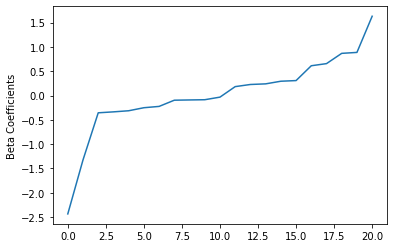

In [246]:
beta = np.sort(lr_trained_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


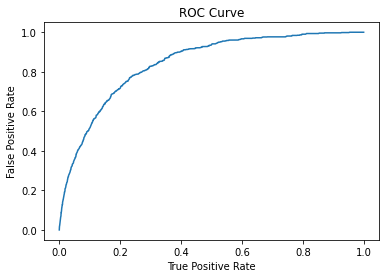

Training set areaUnderROC: 0.8433126860227483


In [247]:
trainingSummary = lr_trained_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


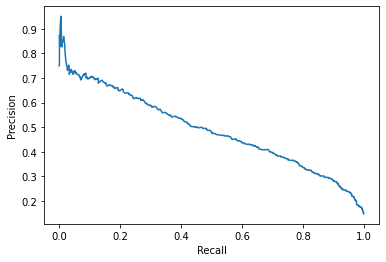

In [248]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [251]:
predictions = lr_trained_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='LabelIndex')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8411344648462572
